In [1]:
import torch
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from glob import glob

In [2]:
labelNameDict = { 1:'Panda', 2:'Snake', 3:'Scissors'}
nameLabelDict = { 'Panda':1, 'Snake':2, 'Scissors':3 }

In [3]:
TEST_ROOT_PATH = 'data/dataset/EfficientDetDataset/test'

class TestDataRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TEST_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
def get_test_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [5]:
test_dataset = TestDataRetriever(
    image_ids=np.array([path.split('\\')[-1][:-4] for path in glob(f'{TEST_ROOT_PATH}/*.jpg')]),
    transforms=get_test_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn
)

130


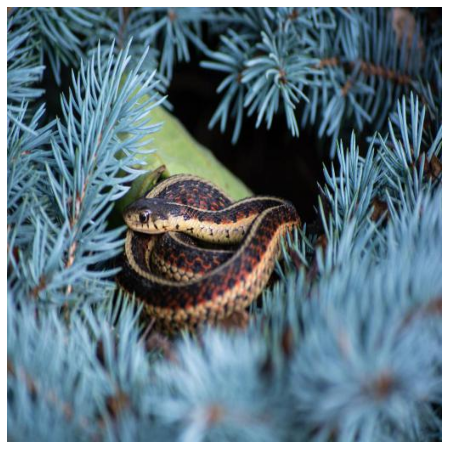

In [6]:
print(len(data_loader))
for j, (images, image_ids) in enumerate(data_loader):
  break

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
ax.imshow(sample);

In [7]:
import gc
from effdet import get_efficientdet_config, DetBenchPredict, EfficientDet
from effdet.efficientdet import HeadNet

def load_net_for_testing():
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.norm_kwargs = dict(eps=.001, momentum=.01)
    config.num_classes = 3
    config.image_size = [512, 512]
    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    checkpoint = torch.load('checkpoints/over-night-200-epochs.bin')
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net)
    net.eval();
    return net.cuda()

net = load_net_for_testing()

In [8]:
def make_predictions(images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    batch_size = 1
    predictions = []
    with torch.no_grad():
        det = net(images)
        print(det[0][0])
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5].astype(int)
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            labels = labels[indexes]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions]
k = 0

130
tensor([315.3329, 202.5040, 378.5125, 314.0142,   0.7132,   1.0000],
       device='cuda:0')


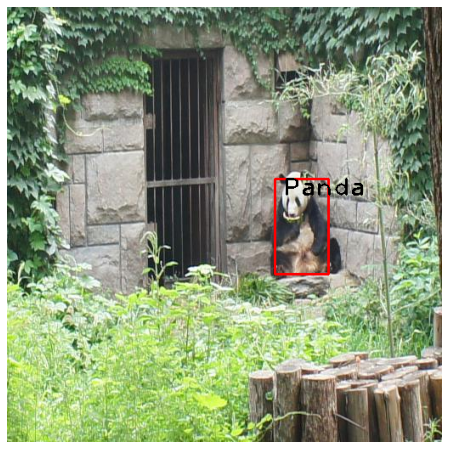

In [45]:
from random import randint

value = randint(0, 129)
print(len(data_loader))
for j, (images, image_ids) in enumerate(data_loader):
  if j == k:
    break
k+=1
predictions = make_predictions(images, 0.5)

boxes = predictions[0][0]['boxes']
labels = predictions[0][0]['labels']

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i, box in enumerate(boxes):
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    cv2.putText(sample, labelNameDict[labels[i]], (box[0]+10, box[1] + 20), 1, 2, (0, 0, 0), 2, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(sample);